In [2]:
import os
import re
import openpyxl as xl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime,date
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations


In [87]:
BOLD = "\033[1m" 
RESET = "\033[0m" 

pd.set_option('display.max_columns', 50)

In [3]:
def get_all_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def convert_to_majority_type(df, column_name):
    type_counts = df[column_name].map(type).value_counts()
    print("distribution types de données\n", type_counts)

    majority_type = type_counts.idxmax()
    print("Type de données", majority_type)
    
    if majority_type == int:
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce').astype('Int64')  
    elif majority_type == float:
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')  
    elif majority_type == str:
        df[column_name] = df[column_name].astype(str) 
    elif majority_type == np.datetime64:
        df[column_name] = pd.to_datetime(df[column_name], errors='coerce')  
    else:
        print(f"Non supporté: {majority_type}.")
        df[column_name] = None 
    
    return df

def processing_valide(path):
    df = pd.read_excel(path)
    # res = None
    if "st100_p_Code_result" in df.columns:
        df.dropna(subset=["st20_b_HORODATAGE"], inplace=True)
        df = df[(df["st100_p_Code_result"]==2) & (~df["st10_a_Code_2D"].str.contains("M")) ]
        df['time index'] = df['st20_b_HORODATAGE'].str.strip().str.split(' ').str[0]
        print("traça 1 succes")
        # df['time index'] = pd.to_datetime(df['st20_b_HORODATAGE'], format='%d/%m/%Y %H:%M:%S').dt.date
        # res = df.groupby('time index', as_index=False)['ID'].count()
    elif "BC04_Code_result" in df.columns:
        df.dropna(subset=["ICP04_HORODATAGE"], inplace=True)

        df = df[
            (
                (df["BC04_HORODATAGE"].isnull() & (df["MJV04_Code_result"] == 2)) |
                (~df["BC04_HORODATAGE"].isnull() & (df["BC04_Code_result"] == 2))
            ) &
                (
                    ~df["SU04_Code_2D"].str.startswith("M")
                    )
        ]

        df['time index'] = df['ICP04_HORODATAGE'].str.strip().str.split(' ').str[0]
        print("traça 2 succes")
        # df['time index'] = pd.to_datetime(df['ICP04_HORODATAGE'], format='%d/%m/%Y %H:%M:%S').dt.date
        # res = df.groupby('time index', as_index=False)['ID'].count()
    else: 
        print ("error")
        
    return df.groupby(df['time index'], as_index=False)['ID'].count()

def processing_globale(path):
    df = pd.read_excel(path)
    
    if "st100_p_Code_result" in df.columns:
        df['time index'] = df['st20_b_HORODATAGE'].str.strip().str.split(' ').str[0]
        print("traça 1 succes")

    elif "BC04_Code_result" in df.columns:
        df['time index'] = df['ICP04_HORODATAGE'].str.strip().str.split(' ').str[0]
        print("traça 2 succes")

    else: 
        print ("error")
        
    return df.groupby(df['time index'], as_index=False)['ID'].count()

def append_to_excel(df, file_path, sheet_name='Sheet1'):
    try:
        book = xl.load_workbook(file_path)
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            writer.book = book
            if sheet_name in writer.book.sheetnames:
                startrow = writer.book[sheet_name].max_row
            else:
                startrow = 0
            df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False, header=not startrow)
    except FileNotFoundError:
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False)

def plot_statistics(col):
    statistics = {
        'Moyen': round(col.mean(),2),
        'Valeur Median': round(col.median(),2),
        'STD': round(col.std(),2),
        'Min': round(col.min(),2),
        'Max': round(col.max(),2)
        # 'Taille': round(col.count(),2)
    }

    stats_df = pd.DataFrame(list(statistics.items()), columns=['Statistic', 'Value'])

    plt.figure(figsize=(8, 5))
    plt.bar(stats_df['Statistic'], stats_df['Value'])
    plt.title(f'Chiffres statistiques [Taille:{col.count()}]')
    plt.xlabel(col.name)
    plt.ylabel('Valeur')
    for i,v in enumerate(stats_df['Value']):
        plt.text(i,v,str(v),ha="center", va="bottom")
    # plt.text(1,5,f"Taille:{col.count()}")
    plt.tight_layout()
    plt.show()

def custom_to_datetime(date_series, year=2024):
    mois_francais = {
        'janvier': 1, 'févr': 2, 'mars': 3, 'avr': 4, 'mai': 5, 'juin': 6,
        'juil': 7, 'août': 8, 'sept': 9, 'oct': 10, 'novembre': 11, 'décembre': 12
    }
    
    def parse_date(date_str):
        jour, mois = date_str.split('-')  
        mois_num = mois_francais.get(mois.lower()) 
        return date(year, mois_num, int(jour))  
    return date_series.apply(parse_date)



Lecture des données

In [4]:
filename = r"../data/2024_11_28_Data_V1.xlsx"

df = pd.read_excel(filename,skiprows=[0])
df = df.iloc[:,:-2]
copy = df.copy()


### Types de données de chaque colonne

In [ ]:
df.dtypes

 Date de fab                                  object
 n°                                           object
 LOT Numero                                   object
 Diamètre axe planétaire avant assemblage     object
 Diamètre axe planétaire après assemblage     object
 Diamètre cible                               object
 Serrage                                     float64
 Rayons axes                                  object
 Accostage                                    object
 Emmanchement                                float64
 Ratio                                       float64
 Dégraissée                                   object
 Collé                                        object
 Graissée                                     object
-0.9                                         float64
-0.8                                         float64
-0.7                                          object
-0.6                                          object
-0.5                                          

In [6]:
df[0.5].value_counts()

0.5
x        7
70.44    1
Name: count, dtype: int64

In [7]:
df.describe()

,Serrage,Emmanchement,Ratio,-0.9,-0.8
count,71.000000,177.000000,177.000000,0.0,0.0
mean,0.071169,525.817078,1.669581,NaN,NaN
std,0.001867,63.884221,0.278050,NaN,NaN
min,0.069000,394.480000,1.065015,NaN,NaN
25%,0.070000,494.000000,1.480000,NaN,NaN
50%,0.071000,519.000000,1.706215,NaN,NaN
75%,0.072000,542.000000,1.910112,NaN,NaN
max,0.076000,823.240000,2.150106,NaN,NaN


In [ ]:
for col in df.columns:
    try:
        df[col] = convert_to_majority_type(df,col)
    except Exception as e:
        print(e)
    

distribution types de données
 Date de fab
<class 'datetime.datetime'>    329
<class 'float'>                 15
<class 'str'>                    4
Name: count, dtype: int64
Type de données <class 'datetime.datetime'>
Non supporté: <class 'datetime.datetime'>.
Columns must be same length as key
distribution types de données
 n°
<class 'str'>      215
<class 'int'>      127
<class 'float'>      6
Name: count, dtype: int64
Type de données <class 'str'>
Columns must be same length as key
distribution types de données
 LOT Numero
<class 'str'>      236
<class 'float'>     93
<class 'int'>       19
Name: count, dtype: int64
Type de données <class 'str'>
Columns must be same length as key
distribution types de données
 Diamètre axe planétaire avant assemblage
<class 'float'>    347
<class 'str'>        1
Name: count, dtype: int64
Type de données <class 'float'>
Columns must be same length as key
distribution types de données
 Diamètre axe planétaire après assemblage
<class 'float'>    337
<c

In [32]:
types = [
    "Date",
    "Integer",
    "String",
    "Float",
    "Float",
    "Float",
    "Float",
    "String",
    "Float",
    "Float",
    "Float",
    "Float", # colonne Dégraissée 
    "Float", # colonne Collé 
    "Float", # colonne Graissée 
    "Float", # colonne Process Misalignment
    "Float",
    "Float",
    "Date"
]

columns_list = list(df.drop(df.columns[list(range(14,29))],axis=1).columns)
columns_list[14] = "Process Misalignment"

for k, v in zip(columns_list, types):
    print(f"Type de colonne {BOLD}{k}{RESET}: {v}\n")

Type de colonne Date de fab: Date

Type de colonne n°: Integer

Type de colonne LOT Numero: String

Type de colonne Diamètre axe planétaire avant assemblage: Float

Type de colonne Diamètre axe planétaire après assemblage: Float

Type de colonne Diamètre cible: Float

Type de colonne Serrage: Float

Type de colonne Rayons axes: String

Type de colonne Accostage: Float

Type de colonne Emmanchement: Float

Type de colonne Ratio: Float

Type de colonne Dégraissée: Float

Type de colonne Collé: Float

Type de colonne Graissée: Float

Type de colonne Process Misalignment: Float

Type de colonne Desalignement: Float

Type de colonne Torque test: Float

Type de colonne Date torque test: Date



Correction d'une erreur d'écriture dans la colonne "Torque test"

In [5]:
# Correction d'une erreur d'écriture:  de O.172 à 0.172 
df.iloc[80,-2] = 0.172

Affichage des valeurs statistiqeus des colonnes numériques

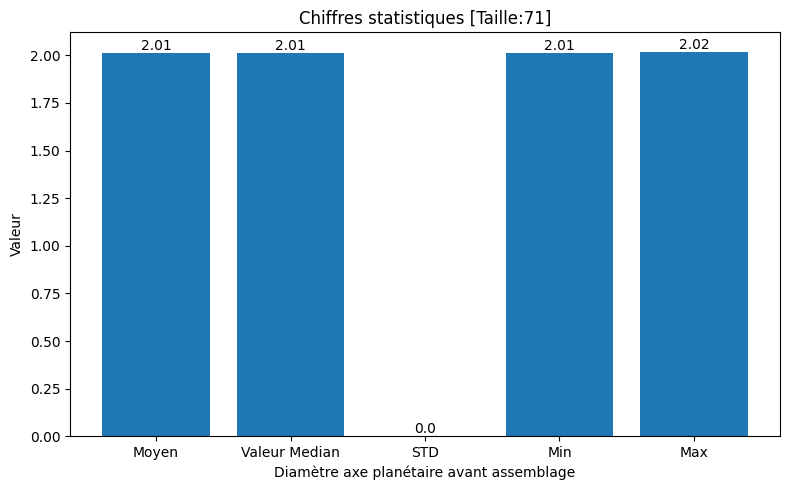

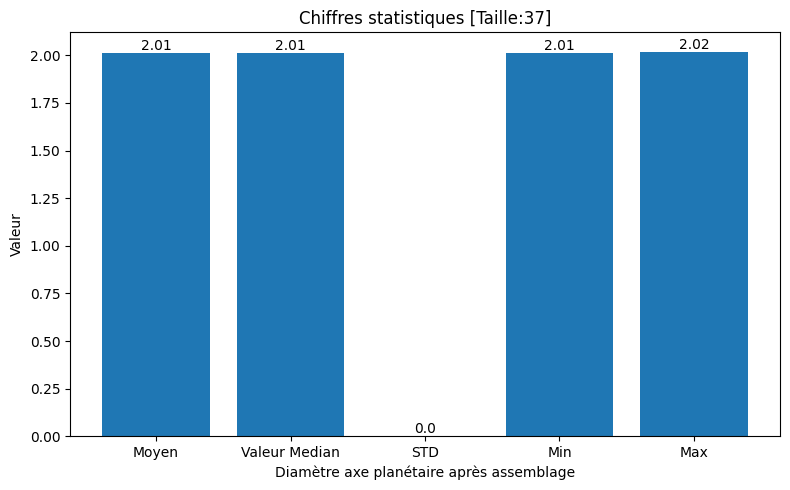

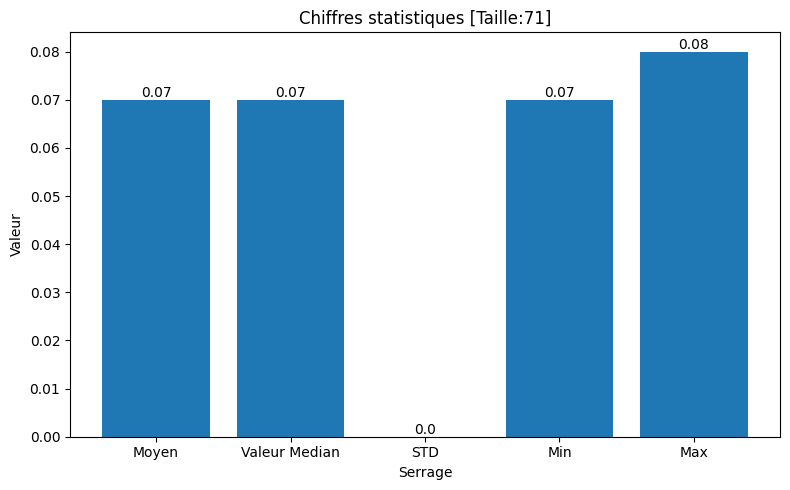

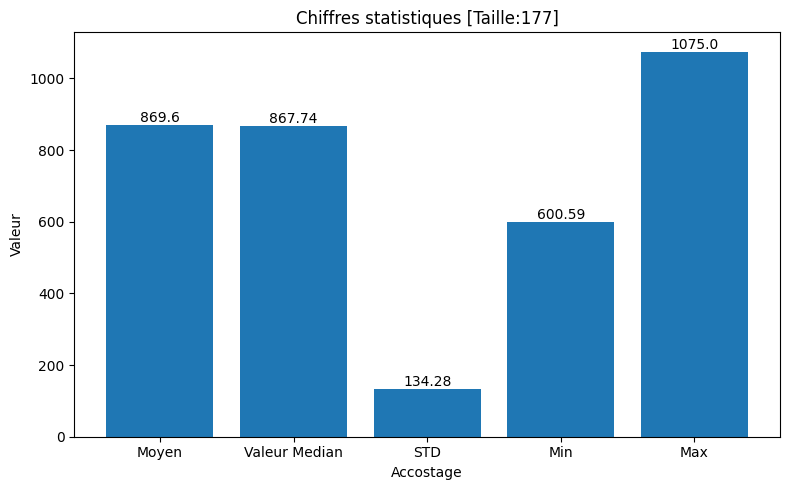

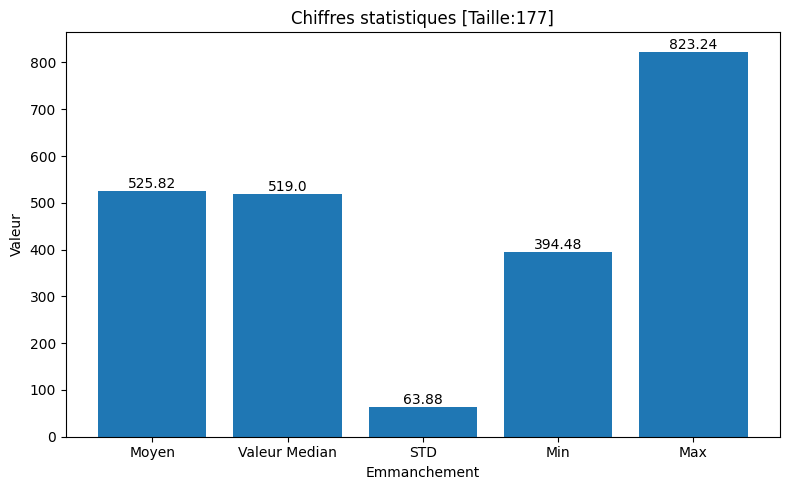

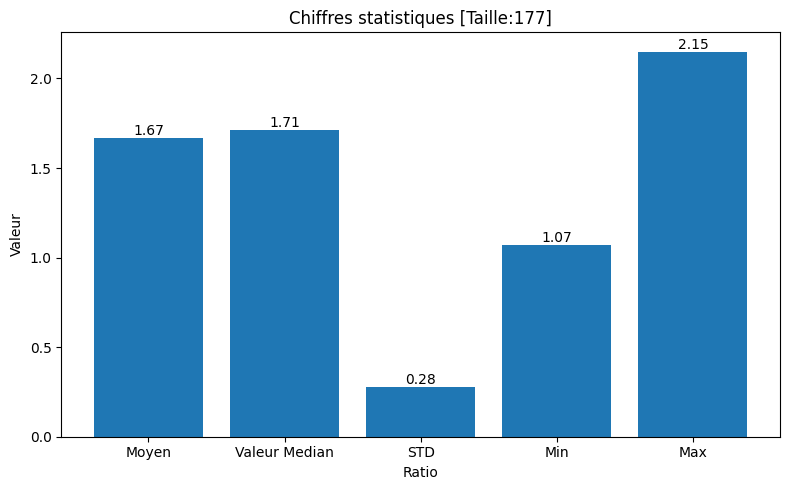

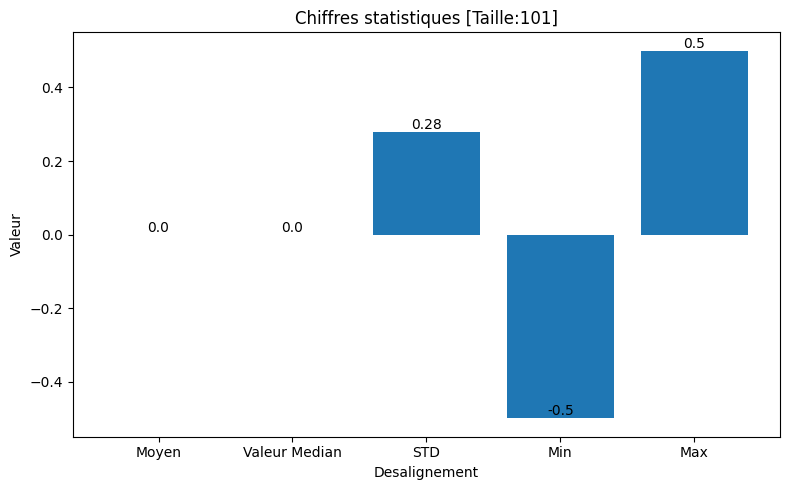

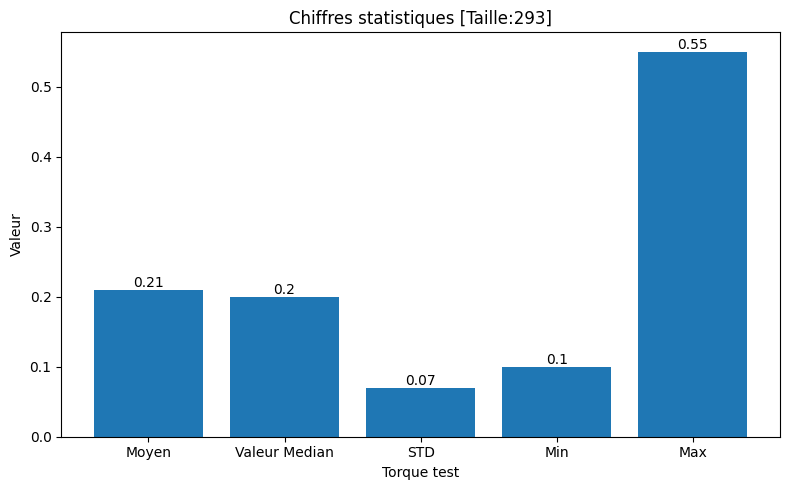

Diamètre axe planétaire avant assemblage    None
Diamètre axe planétaire après assemblage    None
Serrage                                     None
Accostage                                   None
Emmanchement                                None
Ratio                                       None
Desalignement                               None
Torque test                                 None
dtype: object

In [7]:
numerical_columns = [
    'Diamètre axe planétaire avant assemblage',
    'Diamètre axe planétaire après assemblage',
    'Serrage',
    'Accostage',
    'Emmanchement',
    'Ratio',
    'Desalignement',
    'Torque test'
    ]
copy = copy[numerical_columns]
copy = copy.apply(lambda x: pd.to_numeric(x, errors="coerce"))
copy.apply(plot_statistics)

In [8]:
copy.describe()

,Diamètre axe planétaire avant assemblage,Diamètre axe planétaire après assemblage,Serrage,Accostage,Emmanchement,Ratio,Desalignement,Torque test
count,71.000000,37.000000,71.000000,177.000000,177.000000,177.000000,101.000000,293.000000
mean,2.011169,2.012324,0.071169,869.603674,525.817078,1.669581,0.004455,0.211587
std,0.001867,0.002001,0.001867,134.284400,63.884221,0.278050,0.276776,0.071032
min,2.009000,2.009000,0.069000,600.590000,394.480000,1.065015,-0.500000,0.103000
25%,2.010000,2.011000,0.070000,742.060000,494.000000,1.480000,-0.200000,0.164000
50%,2.011000,2.012000,0.071000,867.740000,519.000000,1.706215,0.000000,0.200000
75%,2.012000,2.013000,0.072000,1003.000000,542.000000,1.910112,0.200000,0.240000
max,2.016000,2.017000,0.076000,1075.000000,823.240000,2.150106,0.500000,0.550000


## Distribution du misalignement

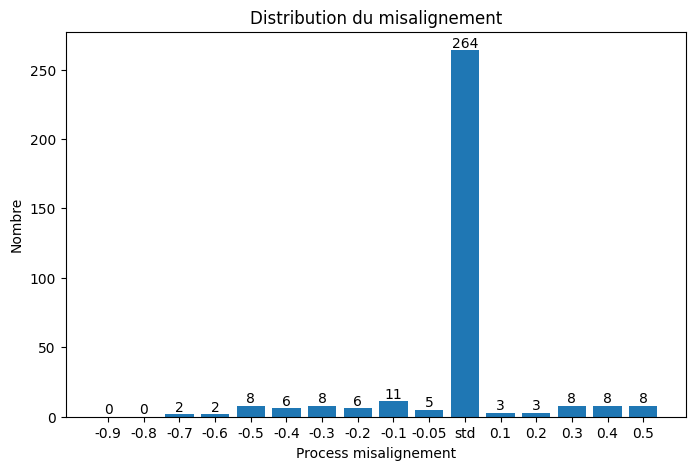

In [9]:

count_process_misalignment = df.iloc[:,14:30].count().to_dict()

count = pd.DataFrame(list(count_process_misalignment.items()), columns=['misalignement', 'count'])

plt.figure(figsize=(8, 5))
plt.bar(count['misalignement'].astype(str), count['count'])
for i,v in enumerate(count['count']):
    plt.text(i, v, str(v),ha='center', va='bottom')
plt.xlabel("Process misalignement")
plt.ylabel("Nombre")
plt.title("Distribution du misalignement")
plt.show()



#### Grand rayon VS Petit rayon

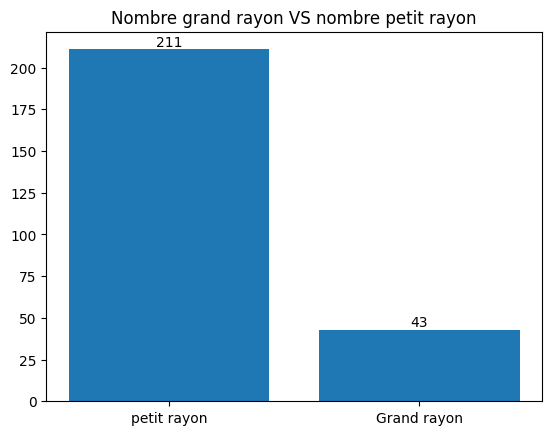

In [10]:
rayons = df["Rayons axes"][df["Rayons axes"]!="Moyenne"]
rayon_counts = rayons.value_counts()

plt.bar(rayon_counts.index, rayon_counts.values)
plt.title("Nombre grand rayon VS nombre petit rayon")
for i, v in enumerate(rayon_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()


Dégraissé, Collé, Graissé

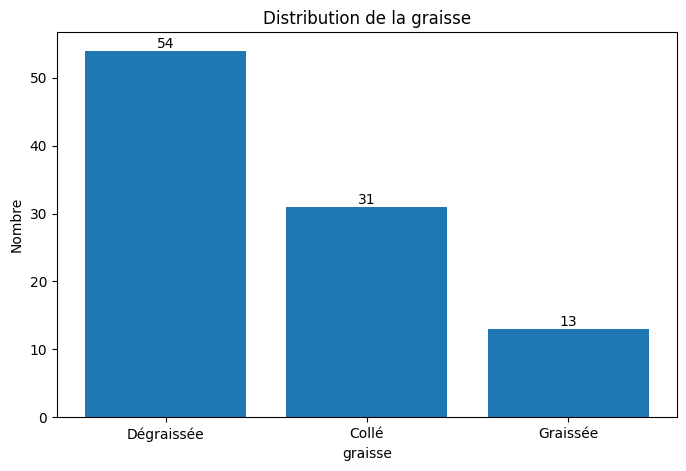

In [11]:
count_graiss = df.iloc[:,11:14].count().to_dict()

count = pd.DataFrame(list(count_graiss.items()), columns=['graisse', 'count'])

plt.figure(figsize=(8, 5))
plt.bar(count['graisse'].astype(str), count['count'])
for i,v in enumerate(count['count']):
    plt.text(i, v, str(v),ha='center', va='bottom')
plt.xlabel("graisse")
plt.ylabel("Nombre")
plt.title("Distribution de la graisse")
plt.show()

Combinaison des colones de process en une colonne

In [67]:
filename = r"../data/2024_11_28_Data_V1 - Copie.xlsx"
                        
df = pd.read_excel(filename,skiprows=[0])
df = df.iloc[:,:-2]
copy = df.copy()


In [68]:
copy.rename(columns={'std': 0}, inplace=True)
mis_df = copy.iloc[:,14:30].notnull()

non_null_indices = {col: mis_df.index[copy[col].notna()].tolist() for col in mis_df.columns}

STD_VALUE = 69.94
non_null_valeur = [round(STD_VALUE + val,2) for val in non_null_indices]


In [69]:
key_mapping = {old_key : new_key for old_key, new_key in zip(non_null_indices.keys(), non_null_valeur)} 

for old_key, new_key in key_mapping.items():
    non_null_indices[new_key] = non_null_indices.pop(old_key)
non_null_indices

{69.04: [],
 69.14: [],
 69.24: [339, 342],
 69.34: [341, 347],
 69.44: [47, 48, 49, 88, 89, 90, 344, 346],
 69.54: [50, 51, 52, 85, 86, 87],
 69.64: [13, 14, 53, 54, 55, 82, 83, 84],
 69.74: [10, 11, 12, 79, 80, 81],
 69.84: [5, 6, 7, 8, 9, 76, 77, 78, 340, 343, 345],
 69.89: [0, 1, 2, 3, 4],
 69.94: [21,
  22,
  23,
  24,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  65,
  66,
  67,
  68,
  69,
  71,
  72,
  73,
  74,
  75,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  

In [70]:
copy['Processus Misalignment'] = 0 * len(df)
for k, v in non_null_indices.items():
    if v != None:
        copy.loc[v, 'Processus Misalignment'] = k

copy['Processus Misalignment'][copy['Processus Misalignment']==0] = np.nan

df['Processus Misalignment'] = copy['Processus Misalignment']

C:\Users\zhangx\AppData\Local\Temp\ipykernel_11084\997487251.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.24' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  copy.loc[v, 'Processus Misalignment'] = k
C:\Users\zhangx\AppData\Local\Temp\ipykernel_11084\997487251.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a

Combinaison des colonnes Dégraissé, Collé, Graissé en une colonne

In [ ]:
copy = df.copy()

In [ ]:
copy.rename(columns={-0.9:"Normal"},inplace=True)
gra_df = copy.iloc[:,11:15].notnull()

non_null_indices = {col: gra_df.index[copy[col].notna()].tolist() for col in gra_df.columns}
non_null_indices

{'Dégraissée': [27,
  28,
  29,
  30,
  31,
  32,
  107,
  108,
  109,
  110,
  111,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  146,
  147,
  148,
  149,
  150,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  322,
  328],
 'Collé': [33,
  34,
  35,
  36,
  37,
  38,
  110,
  111,
  112,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  288,
  290,
  291,
  292,
  293,
  294,
  295,
  297,
  298],
 'Graissée': [39, 40, 41, 42, 43, 44, 112, 113, 114, 115, 116, 288, 298],
 'Normal': []}

In [ ]:
new_keys = [0,1,2,3]
key_mapping = {old_key : new_key for old_key, new_key in zip(non_null_indices.keys(), new_keys)} 

for old_key, new_key in key_mapping.items():
    non_null_indices[new_key] = non_null_indices.pop(old_key)


In [183]:
non_null_indices[3] = [_ for _ in range(len(df))]
value_set = [set(v) for k, v in non_null_indices.items()]
value_set[3] = value_set[3] - value_set[2] - value_set[1] - value_set[0] 
non_null_indices[3] = list(value_set[3])


In [184]:
copy['Etat graisse'] = 0 * len(df)
for k, v in non_null_indices.items():
    if v != None:
        copy.loc[v, 'Etat graisse'] = k

df['Etat graisse'] = copy['Etat graisse']

In [186]:
df.columns

Index([                             'Date de fab',
                                             'n°',
                                     'LOT Numero',
       'Diamètre axe planétaire avant assemblage',
       'Diamètre axe planétaire après assemblage',
                                 'Diamètre cible',
                                        'Serrage',
                                    'Rayons axes',
                                      'Accostage',
                                   'Emmanchement',
                                          'Ratio',
                                     'Dégraissée',
                                          'Collé',
                                       'Graissée',
                                             -0.9,
                                             -0.8,
                                             -0.7,
                                             -0.6,
                                             -0.5,
                               

#### SANDBOX 16 dec - étude de l'ACP



In [ ]:
# filename = r"../data/2024_11_28_Data_V1 - Copie.xlsx"
# df = pd.read_excel(filename, sheet_name="Misalignment-Colle-Dégraissée",skiprows=[0])
# df = df.iloc[:,:-2]
filename = r"T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\2_Echange_EFI\tableaux selon type de graissage\tab_Normale.xlsx"
df = pd.read_excel(filename)
df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))

df = df[["Accostage","Emmanchement","Ratio","Torque test"]]

df = df[
    (df["Accostage"].notna()) & 
    (df["Emmanchement"].notna()) &
    (df["Ratio"].notna()) &
    (df["Torque test"].notna()) 
]

In [49]:
parameters = df.drop(columns=['Torque test'])
y = df["Torque test"]

# x = df.iloc[:,0:-1]
# scaler = StandardScaler()
# x = scaler.fit_transform(x)

combination = [list(comb) for comb in combinations(parameters.columns, 2)]
combination


[['Accostage', 'Emmanchement'],
 ['Accostage', 'Ratio'],
 ['Emmanchement', 'Ratio']]

In [ ]:

# df = df[["Accostage","Emmanchement","Ratio","Torque test"]]
# y_list = list(df.columns)
# y_list.remove(Y)
# df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
# # df['Accostage'] = pd.to_numeric(df['Accostage'], errors="coerce")
# # df['Emmanchement'] = pd.to_numeric(df['Emmanchement'], errors="coerce")
# # df['Ratio'] = pd.to_numeric(df['Ratio'], errors="coerce")
# # df['Torque test'] = pd.to_numeric(df['Torque test'], errors="coerce")
# for col in y_list:
#     copy = df[df[col].notna() & df[Y].notna()]

#     x = copy[col]
#     y = copy[Y]

#     t_stat, p_value = stats.pearsonr(x, y)
#     print(f"Pour x = {col} y = {Y}")
#     print(f"Coef de corrélation: {t_stat}, P-value: {p_value}")

#     plt.scatter(x, y, color='blue')
#     plt.title(f"Pearson Correlation: {t_stat:.2f} (p-value: {p_value:.2e})")
#     plt.xlabel(x.name)
#     plt.ylabel(y.name)
#     plt.grid()
#     plt.show()

1. compléter les graphes de PCA avant 17h, refait le PCA pour la famille Normale
2. courbes de diamètre cible - torque test / acco / emman/ ratio
3. questiones sur les données

BONUS: pour la famille Normale, effectue PCA pour : Y=Torque test, X= diametre / acco / emman/ ratio / .. toutes les parametres 

[-1.58011464 -2.16468522 -2.1116853  -1.95876021 -2.54439897 -0.69760711
 -2.39659025 -2.0375463  -1.38428453 -1.20535344 -2.52255044 -1.34310896
 -1.3878404  -1.80407044 -1.80899035 -0.67498849 -2.63051449 -0.62322819
 -2.33760197 -1.63626698 -1.17470574 -0.68887179 -0.74410736 -1.33453493
 -0.79328825 -1.58342779 -1.42925889  0.49192058  0.45103179  0.93244538
  1.26087348  0.84267563  1.19267425  0.81535546  0.63451792  0.98345468
 -0.32093371 -0.50561166 -0.34660994  0.57021384  0.23157346  0.1691775
 -0.05146028 -0.53261019 -0.38290979 -0.38487534 -0.21698139 -1.28515145
 -0.49118709  0.23151103  0.18648235  1.34734154  0.71274624  1.44164035
  1.14536486  1.31602471  1.11046959  1.22765146  1.14402789  1.69182036
  0.87265456  1.41045065  1.25145802  0.6419279   1.19074102  0.37396669
  1.47050767  0.59476284  1.6169984   1.82076333  1.04342272  1.69010711
  1.29705526  1.06933054  1.04738717  1.57338438  1.70417624  1.43486893
  1.52315873  1.5478542   1.81074157] (81,)
[-1.5801

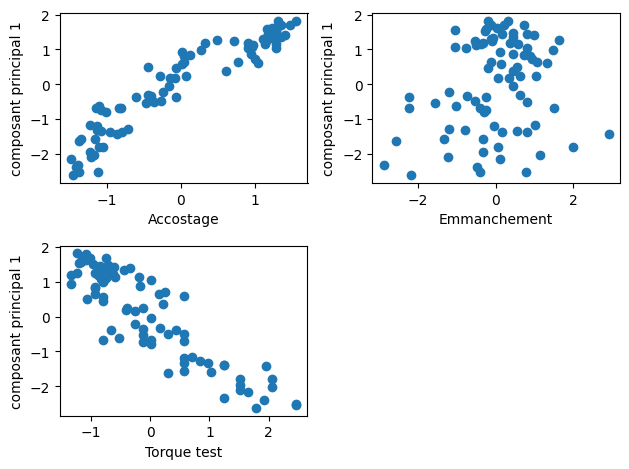

[-1.54228029 -2.71457818 -1.94424222 -2.22089366 -2.59672455 -1.6610364
 -2.63149456 -2.82293852 -1.69140124 -1.6627997  -3.20042453 -1.97930799
 -2.04216537 -2.86923923 -2.17841258 -0.22027971 -2.06844736 -0.75216359
 -1.39102466 -0.99368434 -2.09783378 -0.91089665 -1.17890649 -1.44490724
 -1.1417593  -1.83831369 -2.74731506 -0.11914899  0.40516965  0.70746751
  0.58198337  0.42317919  0.98248784  0.28417972  0.58887046  0.30558351
 -0.81282704 -0.98576912 -0.19556213  0.39590229 -0.43673399 -0.08375157
 -0.35148723  0.01473785  0.41175595 -0.24727385  0.24394548 -0.93896208
 -0.32909515 -0.06889824  0.03372841  1.67435336  0.71724708  1.78606884
  1.80634386  1.8428143   1.74106098  1.72724094  1.40993458  2.0752788
  1.05061878  1.48723313  1.72189525  0.47773845  1.67516382  0.44749647
  1.72567766  0.47153622  2.03877656  2.08846764  1.78496279  1.87954054
  1.77285756  2.00194008  1.21652133  2.11079221  2.24036105  1.49774752
  2.15355288  2.60448405  2.50628232] (81,)
[-1.54228

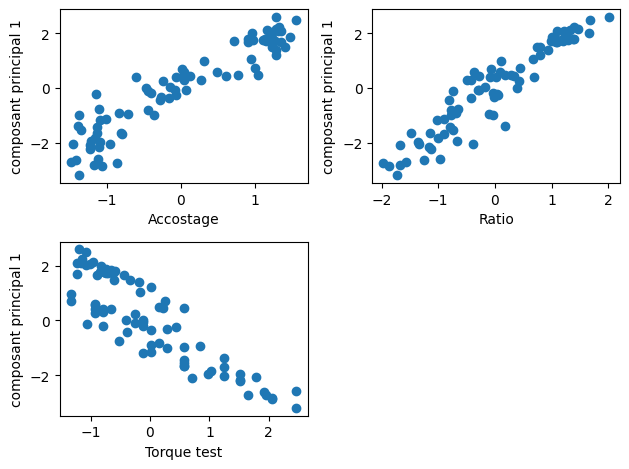

[-0.5038002  -2.20573632 -1.10434781 -1.68478987 -2.17775253 -1.83362304
 -1.9954139  -2.84856532 -1.49437911 -1.16051679 -3.04988219 -1.73827573
 -1.97932639 -3.22996294 -1.82340242  1.17896713 -0.81537013  0.18081422
  0.14158454  0.52125142 -1.91746471 -0.37446648 -0.56636434 -0.69002789
 -0.55639189 -1.26908971 -3.48733141  0.02064647  0.5865619   0.7993977
 -0.11513546  0.2096016   0.84160144  0.0525109   0.70659852 -0.24245558
 -0.82574897 -1.14010982  0.26752505  0.4202649  -0.60655143 -0.14009671
 -0.43299171  0.78947269  1.55061098 -0.17298623  0.80264912 -0.27420889
 -0.04340144 -0.30539961  0.11949371  0.90427491 -0.12451299  1.2470224
  1.4510781   1.33760591  1.52053851  1.27187012  0.60532689  1.4475669
  0.44974462  0.49615156  1.6900223  -0.28015689  1.44448597 -0.02904867
  1.02492628 -0.55046251  1.54406919  1.46794758  1.69458947  0.98716594
  1.35987443  1.99423554  0.308749    1.75824055  1.75860468  0.68653679
  1.73439177  2.4828768   1.93209954] (81,)
[-0.503800

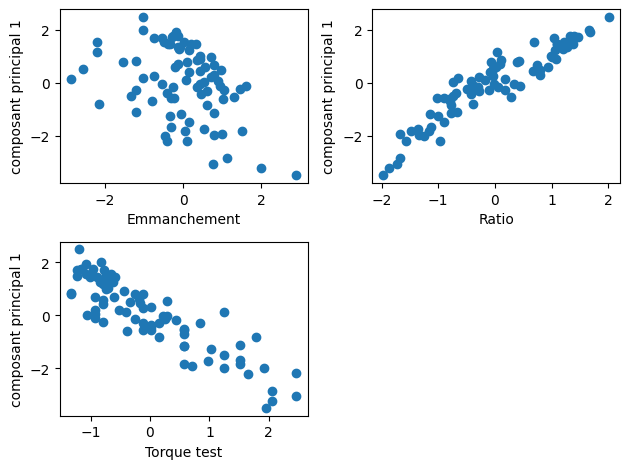

In [ ]:
combination = [list(comb) for comb in combinations(parameters.columns, 2)]

for _ in combination:
    
    tmp = _
    tmp.append("Torque test")
    for col in df[tmp]:
        x = df[_]
        pca = PCA(n_components=2)

        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        pc = pca.fit_transform(x)
       
        # col_x = df[col]      
        # print(col_x.to_frame().T)
        df[col]  = scaler.fit_transform(df[[col]] )

        # t_stat, p_value = stats.pearsonr(x, y)
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        i = df[tmp].columns.get_loc(col)
        plt.subplot(2,2,i+1)
        # plt.scatter(df[col],pc)
        plt.scatter(df[col],pc[:,0])
        plt.ylabel("composant principal 1")
        plt.xlabel(col)
        
    print(f"Colonnes sélectionnées:{_}")
    print("explained_variance_ratio", explained_variance_ratio)
    print("cumulative_variance_ratio", cumulative_variance_ratio)
    print()
    plt.tight_layout()
    plt.show()

In [92]:
filename = r"../data/tab_Normale.xlsx"
df = pd.read_excel(filename)
df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
df['Processus Misalignment'] = copy['Processus Misalignment']


In [94]:
cols = [    
    # 'Diamètre axe planétaire avant assemblage',
    # 'Diamètre axe planétaire après assemblage',
    'Serrage',
    'Accostage',
    'Emmanchement',
    'Ratio',
    'Desalignement',
    'Processus Misalignment'
    ]

Questions à poser de mon côté:
1. les échantillons non identifiés: Mohammad et moi, On a traité que les 108 premiers échantillons car les restes échantillons ont d'état de graissage avec une valeur de vitesse. On en comprenais pas, et on a mis non-identifiés pour ces restes échantillons. Pourquoi il y a de vitesse dans l'état de graissage?

1. les Moyenne dans le Rayon axes: On pensait que les lignes avec "Moyenne" dans la colonnes Rayon axes ne correspond pas à un vrai échantillon. On pensait que c'est juste pour calculer la valeur moyenne pour les échantillons ayant le même n° de lot.

(46, 6)
Colonnes sélectionnées:['Emmanchement', 'Ratio', 'Torque test']
explained_variance_ratio [0.39362852 0.28717384 0.17744463 0.08693938]
cumulative_variance_ratio [0.39362852 0.68080236 0.85824698 0.94518636]



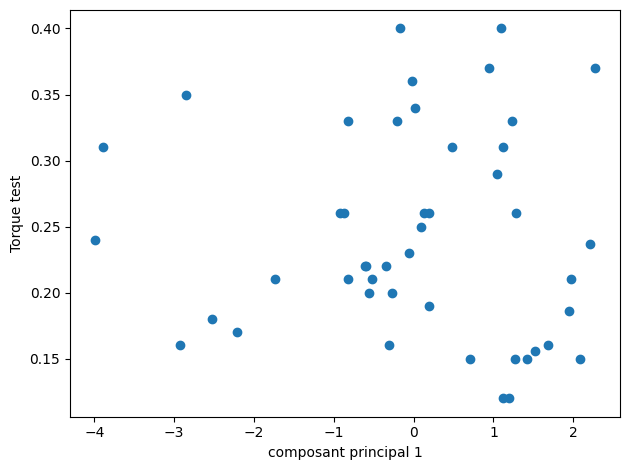

In [95]:
df = df[df[cols].notna().all(axis=1)]

x = df[cols]
print(x.shape)
pca = PCA(n_components=4)

scaler = StandardScaler()
x = scaler.fit_transform(x)
pc = pca.fit_transform(x)

# col_x = df[col]      
# print(col_x.to_frame().T)
# df[col]  = scaler.fit_transform(df[[col]] )

# t_stat, p_value = stats.pearsonr(x, y)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# i = df[tmp].columns.get_loc(col)
# plt.subplot(2,2,i+1)
# plt.scatter(df[col],pc)
plt.scatter(pc[:,0],df['Torque test'])
plt.xlabel("composant principal 1")
plt.ylabel('Torque test')

print(f"Colonnes sélectionnées:{_}")
print("explained_variance_ratio", explained_variance_ratio)
print("cumulative_variance_ratio", cumulative_variance_ratio)
print()
plt.tight_layout()
plt.show()

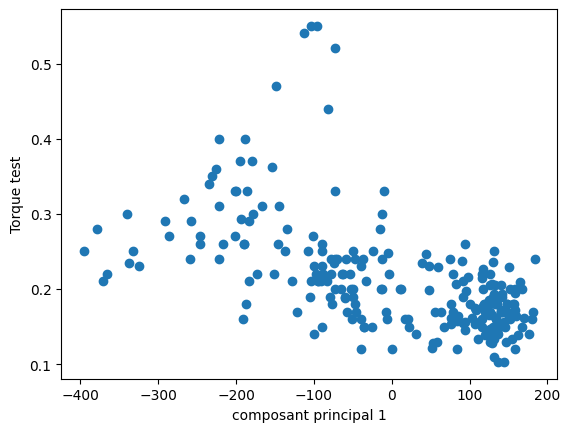

In [72]:
# plt.scatter(x[:,0], x[:,1])
plt.scatter(x,df['Torque test'])
plt.ylabel("Torque test")
plt.xlabel("composant principal 1")
plt.show()

### Taches pour la suite

1. séparer les 4 tableaux en fonction de famille dégraissée/ collé...
2. Pour chaque famille(tableau), prendre les col emman/ accostage/ratio(y est toujours le torque test)  trouver p-value pour l'hypothèse pour chaque famille(tableau)     normale à priosier
3. souligner les paramètres plus importants à l'effort emman/accos/ratio

Pour la famille Normale

In [77]:
# filename = r"../data/2024_11_28_Data_V1 - Copie.xlsx"
directory_path = r"t:\PROCESSUS_R1\STAGIAIRES\REP_XZ\2_Echange_EFI\tableaux selon type de graissage"
filelist = get_all_file_paths(directory_path)

# df = pd.read_excel(filename)
# df = df.iloc[:,:-2]
# df

In [85]:
df = pd.read_excel(filelist[0])

df = df[["Accostage","Emmanchement","Ratio","Torque test"]]

tmp = list(df.columns)
tmp

['Accostage', 'Emmanchement', 'Ratio', 'Torque test']

In [92]:
def hypo_test(Y, file):
    df = pd.read_excel(file)
    
    df = df[["Accostage","Emmanchement","Ratio","Torque test"]]
    y_list = list(df.columns)
    y_list.remove(Y)
    df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
    # df['Accostage'] = pd.to_numeric(df['Accostage'], errors="coerce")
    # df['Emmanchement'] = pd.to_numeric(df['Emmanchement'], errors="coerce")
    # df['Ratio'] = pd.to_numeric(df['Ratio'], errors="coerce")
    # df['Torque test'] = pd.to_numeric(df['Torque test'], errors="coerce")
    for col in y_list:
        copy = df[df[col].notna() & df[Y].notna()]

        x = copy[col]
        y = copy[Y]

        t_stat, p_value = stats.pearsonr(x, y)
        print(f"Pour x = {col} y = {Y}")
        print(f"Coef de corrélation: {t_stat}, P-value: {p_value}")

        plt.scatter(x, y, color='blue')
        plt.title(f"Pearson Correlation: {t_stat:.2f} (p-value: {p_value:.2e})")
        plt.xlabel(x.name)
        plt.ylabel(y.name)
        plt.grid()
        plt.show()

Pour x=Accostage y=Torque test
Coef de corrélation: 0.1057081410874863, P-value: 0.8420283909101068


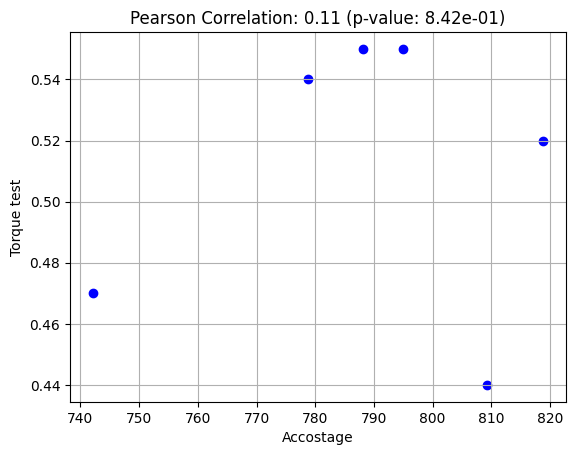

Pour x=Emmanchement y=Torque test
Coef de corrélation: 0.3101200754859318, P-value: 0.5497327023576921


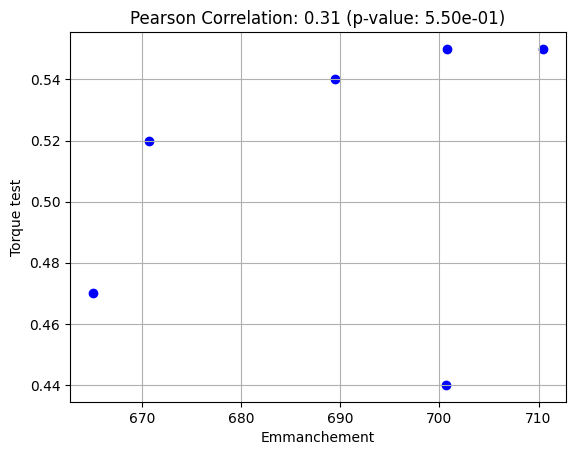

Pour x=Ratio y=Torque test
Coef de corrélation: -0.11739962688126608, P-value: 0.8247095999762165


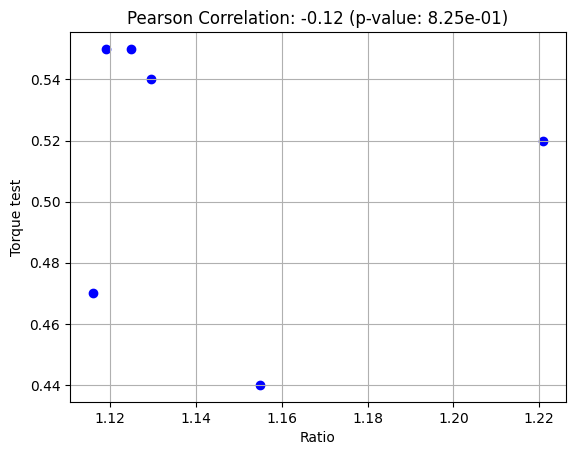

In [91]:
hypo_test("Torque test",filelist[0])

In [71]:
df['Accostage'] = pd.to_numeric(df['Accostage'], errors="coerce")
df['Emmanchement'] = pd.to_numeric(df['Emmanchement'], errors="coerce")
df['Ratio'] = pd.to_numeric(df['Ratio'], errors="coerce")
df['Torque test'] = pd.to_numeric(df['Torque test'], errors="coerce")

In [72]:
df['Accostage']

0       674.29
1       655.97
2       690.81
3       689.97
4       703.23
        ...   
101    1053.00
102    1034.00
103    1025.00
104     965.00
105     997.00
Name: Accostage, Length: 106, dtype: float64

In [73]:
copy = df[df['Accostage'].notna() & df['Torque test'].notna()]

In [74]:

x = copy['Accostage']
y = copy['Torque test']

t_stat, p_value = stats.pearsonr(x, y)
alpha = 0.05
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.5487304470280001, P-value: 4.096339237464787e-09


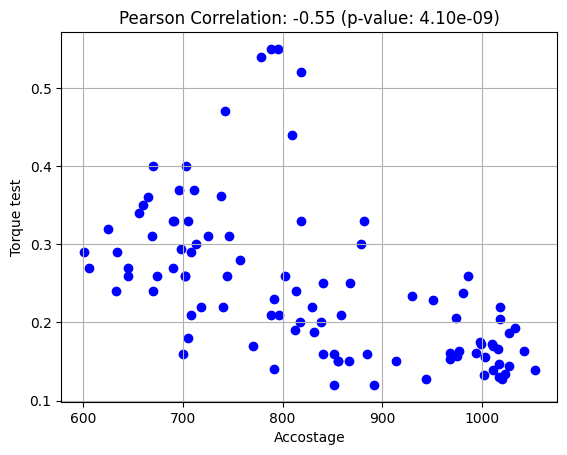

In [75]:
plt.scatter(x, y)
plt.title(f"Pearson Correlation: {t_stat:.2f} (p-value: {p_value:.2e})")
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.grid()
plt.show()

Division des 5 familles(avec famille non-identifié)

In [5]:
filename = r"../data/2024_11_28_Data_V1 - Copie.xlsx"

df = pd.read_excel(filename, sheet_name="Misalignment-Colle-Dégraissée",skiprows=[0])

df = df.iloc[:,:-2]
df

,Date de fab,n°,LOT Numero,Diamètre axe planétaire avant assemblage,Diamètre axe planétaire après assemblage,Diamètre cible,Serrage,Rayons axes,Accostage,Emmanchement,...,-0.05,std,0.1,0.2,0.3,0.4,0.5,Desalignement,Torque test,Date torque test
0,2024-07-02 00:00:00,1,NaN,2.013,2.013,1.94,0.073,Grand rayon,674.29,460.25,...,x,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.26,NaN
1,2024-07-02 00:00:00,2,NaN,2.011,2.012,1.94,0.071,Grand rayon,655.97,521.25,...,x,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.34,NaN
2,2024-07-02 00:00:00,3,NaN,2.013,2.013,1.94,0.073,Grand rayon,690.81,465.18,...,x,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.33,NaN
3,2024-07-02 00:00:00,4,NaN,2.012,2.011,1.94,0.072,Grand rayon,689.97,503.56,...,x,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.33,NaN
4,2024-07-02 00:00:00,5,NaN,2.011,2.012,1.94,0.071,Grand rayon,703.23,499.68,...,x,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,NaN,A0283204,240807,NaN,NaN,NaN,NaN,NaN,566.5,325.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23,NaN
344,NaN,A0283201,240807,NaN,NaN,NaN,NaN,NaN,520.2,345.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21,NaN
345,NaN,A0283200,240807,NaN,NaN,NaN,NaN,NaN,553.3,306.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.235,NaN
346,NaN,A0283198,240807,NaN,NaN,NaN,NaN,NaN,559.5,371.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN


In [6]:
df[
    df["Dégraissée"] == "standard\n(avec graisse sur axe)"
   ].index

Index([107], dtype='int64')

In [7]:
_df = df.iloc[:107,:]

graissage = ["Dégraissée", "Collé", "Graissée"]
_df_index = _df.index

for ele in graissage:
    tmp = _df[_df[ele].notnull()].drop(columns=graissage)
    tmp.to_excel(f"../data/tab_{ele}.xlsx", index=False)
    _df_index = _df_index.difference(tmp.index)
_df_index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106],
      dtype='int64')

In [8]:
normal_df = _df.iloc[_df_index,:].drop(columns=graissage)
normal_df.to_excel(f"../data/tab_Normale.xlsx", index=False)

In [9]:
non_id_df_index = df.index.difference(_df.index)
non_id_df_index

non_id_df = df.loc[non_id_df_index,:]
non_id_df.drop(columns=graissage).to_excel(f"../data/tab_Non_identifié.xlsx", index=False)

### Taches de Cyrille

1. combien de pièce produite par jour(pas de ICP04_code 0)
2. traça 2: BC04_code_result ------ filtrer les code 2
    traça 1: st100_p_code_result ------ filtrer les code 2


période 2: 21 02 2024 - 14 10 2024

In [23]:
path = r"T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\période 2.xlsx"
df  = pd.read_excel(path, header=None)
df.columns = ['date','nb']

In [24]:
res = df.groupby('date',as_index=False).sum()
res

,date,nb
0,01-août,1039
1,01-avr,750
2,01-juil,1012
3,01-juin,313
4,01-mai,386
...,...,...
192,30-mai,1304
193,30-mars,327
194,31-août,1059
195,31-juil,1401


In [31]:
res['converted_date'] = custom_to_datetime(res['date'])
res.sort_values(by="converted_date", ascending=True, ignore_index=True, inplace=True)
res

,date,nb,converted_date
0,21-févr,703,2024-02-21
1,22-févr,876,2024-02-22
2,23-févr,709,2024-02-23
3,24-févr,173,2024-02-24
4,26-févr,231,2024-02-26
...,...,...,...
192,10-oct,1302,2024-10-10
193,11-oct,1220,2024-10-11
194,12-oct,1000,2024-10-12
195,13-oct,662,2024-10-13


In [32]:
res.to_excel("Nombre de pièces produites par jour - période 2.xlsx")

ICI générer le tableau de 2eme point

In [ ]:
path 


In [10]:
path = r"T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-03-Mars 2024.xlsx"
df = pd.read_excel(path)


,ID,st10_a_HORODATAGE,st10_a_Code_2D,st10_a_Code_result,st10_a_Code_membrane,st10_a_Rpn,st10_a_Power,st20_b_HORODATAGE,st20_b_Code_result,st20_b_Code_Cible,...,st100_p_Angle_2,st100_p_Couple_3,st100_p_Angle_3,st100_p_Couple_4,st100_p_Angle_4,st110_r_HORODATAGE,st110_r_Code_result,st110_r_type_production,st110_r_OF,st110_r_Marquage
11,32928,01/03/2024 00:14:04,A0035378 A0032030100 29 02 24 12 24,2,S600300263-007,119,258,01/03/2024 00:15:36,2,S022951905,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
27,32944,01/03/2024 00:27:10,A0035518 A0032030100 29 02 24 15 59,2,S600300263-007,121,256,01/03/2024 00:28:06,2,S022951905,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
50,32967,01/03/2024 00:41:52,A0035503 A0032030100 29 02 24 15 52,2,S600300263-007,123,257,01/03/2024 00:50:17,2,S022951905,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
92,33009,01/03/2024 01:13:16,A0035280 A0032030100 29 02 24 10 48,2,S600300263-007,116,261,01/03/2024 01:16:04,2,S022951905,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
105,33022,01/03/2024 01:28:16,A0035351 A0032030100 29 02 24 11 42,2,S600300263-007,122,259,01/03/2024 01:30:46,2,S022951905,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24985,57902,30/03/2024 11:22:24,A0059831 A0032030100 27 03 24 04 02,2,S600307224,122,208,NaN,0,empty,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
25003,57920,30/03/2024 11:35:30,A0057409 A0032030100 25 03 24 14 10,2,S600307224,125,212,30/03/2024 11:36:40,2,S1066180063414-001,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
25004,57921,30/03/2024 11:36:17,A0057407 A0032030100 25 03 24 14 09,2,S600307224,128,211,30/03/2024 11:37:24,2,S1066180063414-001,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty
25005,57922,30/03/2024 11:36:51,A0057405 A0032030100 25 03 24 14 08,2,S600307224,130,214,30/03/2024 11:38:38,2,S1066180063414-001,...,0.0,0.0,0.0,0.0,0.0,NaN,0,empty,empty,empty


In [75]:
df[(df["st100_p_Code_result"]==2) & (~df["st10_a_Code_2D"].str.contains("M")) ].shape
"st100_p_Code_result" in df.columns

True

In [66]:
copy = df[(df["st100_p_Code_result"]==2) & (~df["st10_a_Code_2D"].str.contains("M")) ]

copy['time index'] = copy['st20_b_HORODATAGE'].str.strip().str.split(' ').str[0]
# copy['time index'] = pd.to_datetime(df['st20_b_HORODATAGE'].str.strip(), format='%d/%m/%Y %H:%M:%S').dt.date
# result = df.groupby('date')['id'].count()
result = copy.groupby('time index', as_index=False)['ID'].count()
result
"BC04_Code_result" in copy.columns

C:\Users\zhangx\AppData\Local\Temp\ipykernel_14304\1625535963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['time index'] = copy['st20_b_HORODATAGE'].str.strip().str.split(' ').str[0]


False

In [33]:
directory_path = r"T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem"
all_files = get_all_file_paths(directory_path)

valide_output_list = []
globale_output_list = []

for file in all_files:
    print(f"Processing file: {file}")
    valide = processing_valide(file)
    globale = processing_globale(file)

    valide_output_list.append(valide)
    globale_output_list.append(globale)


Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-02 février 2024.xlsx
traça 1 succes
traça 1 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-03-Mars 2024.xlsx
traça 1 succes
traça 1 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-04-Avril 2024 traça1.xlsx
traça 1 succes
traça 1 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-04-Avril 2024 traça2.xlsx
traça 2 succes
traça 2 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-05 mai 2024.xlsx
traça 2 succes
traça 2 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-06 juin 2024.xlsx
traça 2 succes
traça 2 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-07 juillet 2024.xlsx
traça 2 succes
traça 2 succes
Processing file: T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegard

In [38]:
valide_output_df = pd.concat(valide_output_list)
globale_output_df = pd.concat(globale_output_list)

globale_output_df.shape

(209, 2)

In [50]:
valide_output_df.reset_index(drop=True)
# globale_output_df.drop(index=len(globale_output_df)-1, inplace=True)
valide_output_df['time index'] = pd.to_datetime(valide_output_df['time index'], format='%d/%m/%Y').dt.date
valide_output_df.sort_values(by="time index",inplace=True, ignore_index=True)


In [46]:
valide_output_df

,time index,ID
0,2024-02-21,705
1,2024-02-22,876
2,2024-02-23,709
3,2024-02-24,173
4,2024-02-26,231
...,...,...
203,2024-10-10,1302
204,2024-10-11,1220
205,2024-10-12,1000
206,2024-10-13,662


In [51]:
res = valide_output_df.groupby("time index", as_index=False)["ID"].sum()
res

,time index,ID
0,2024-02-21,560
1,2024-02-22,713
2,2024-02-23,543
3,2024-02-24,122
4,2024-02-26,145
...,...,...
193,2024-10-10,1082
194,2024-10-11,956
195,2024-10-12,859
196,2024-10-13,584


In [54]:
res.tail(20 )

,time index,ID
178,2024-09-19,754
179,2024-09-20,1251
180,2024-09-21,1107
181,2024-09-22,410
182,2024-09-23,938
183,2024-09-24,254
184,2024-10-01,1061
185,2024-10-02,1184
186,2024-10-03,1177
187,2024-10-04,1165


In [52]:
res.to_excel('output.xlsx', index=False)

In [98]:
path = r"T:\PROCESSUS_R1\STAGIAIRES\REP_XZ\6_Sauvegardes\12 dec aprem\2024-10 octobre 2024.xlsx"
df = pd.read_excel(path)


In [99]:
df=df.dropna(subset=['SU04_Code_2D']).reset_index(drop=True)

In [95]:
df

,ID,SU04_Code_2D,CML04G_Marquage,OF,REFERENCE,SU04,ICP04,VMB04,DVI04,SB04,...,MJV04_Angle_2,MJV04_Couple_3,MJV04_Angle_3,MJV04_Couple_4,MJV04_Angle_4,BC04_HORODATAGE,BC04_Code_result,BC04_type_production,BC04_OF,BC04_Marquage
0,146378.0,A0199848 A0032030100 26 08 24 12 03,360359982RT242481012A07,OF,,OK,OK,OK,OK,ATTENTE,...,7.5,1.028870,7.25,1.029968,6.25,04/09/2024 23:01:47,2.0,NaN,NaN,empty
1,146379.0,A0199851 A0032030100 26 08 24 12 04,NaN,OF,REFERENCE,OK,ATTENTE,ATTENTE,ATTENTE,ATTENTE,...,0.0,0.000000,0.00,0.000000,0.00,NaN,0.0,empty,empty,empty
2,146380.0,M901,NaN,OF,REFERENCE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,...,0.0,0.000000,0.00,0.000000,0.00,NaN,0.0,empty,empty,empty
3,146381.0,M1001,NaN,OF,REFERENCE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,...,9.0,1.019531,5.75,1.021545,7.50,NaN,0.0,empty,empty,empty
4,146382.0,M1002,NaN,OF,REFERENCE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,ATTENTE,...,9.0,1.019531,5.75,1.021545,7.50,NaN,0.0,empty,empty,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29593,176301.0,A0235949 A0032030100 30 09 24 06 29,360351188RT242750809A07,OF,REP0030,OK,OK,OK,OK,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29594,176302.0,A0235948 A0032030100 30 09 24 06 29,360358706RT242750285A07,OF,REP0030,OK,OK,OK,OK,ATTENTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29595,176303.0,A0235939 A0032030100 30 09 24 06 21,NaN,OF,REFERENCE,OK,OK,OK,OK,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29596,176304.0,A0235938 A0032030100 30 09 24 06 21,NaN,OF,REFERENCE,OK,OK,OK,OK,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df = df[(df["BC04_Code_result"]==2) & (~df["SU04_Code_2D"].str.startswith("M")) ]
df['time index'] = df['ICP04_HORODATAGE'].str.strip().str.split(' ').str[0]
res = df.groupby(df['time index'], as_index=False)['ID'].count()
res

,time index,ID
0,01/10/2024,1033
1,02/10/2024,1162
2,03/10/2024,1168
3,04/10/2024,1160
4,05/10/2024,646
5,06/10/2024,652
6,07/10/2024,1351
7,08/10/2024,971
8,09/10/2024,1083
9,10/10/2024,1069


In [101]:
output_df = pd.concat([output_df, res])
output_df

,time index,ID
0,01/03/2024,3
1,21/02/2024,560
2,22/02/2024,713
3,23/02/2024,543
4,24/02/2024,122
...,...,...
8,09/10/2024,1083
9,10/10/2024,1069
10,11/10/2024,924
11,12/10/2024,828


In [102]:
output_df.to_excel('output.xlsx', index=False)

In [117]:
global_df = pd.read_excel('Nombre de pièces produites par jour - période 2.xlsx')
global_df.drop(columns=['date'],inplace=True)
global_df.columns = ['date', 'nb_globale']
global_df['date'] = pd.to_datetime(global_df['date'], format='%Y-%m-%d').dt.date

global_df

,date,nb_globale
0,2024-02-21,703
1,2024-02-22,876
2,2024-02-23,709
3,2024-02-24,173
4,2024-02-26,231
...,...,...
192,2024-10-10,1302
193,2024-10-11,1220
194,2024-10-12,1000
195,2024-10-13,662


In [120]:
output_df['date avec formats'] = pd.to_datetime(output_df['time index'], format='%d/%m/%Y').dt.date
output_df.sort_values(by="date avec formats",inplace=True, ignore_index=True)
output_df

,time index,ID,date avec formats
0,21/02/2024,560,2024-02-21
1,22/02/2024,713,2024-02-22
2,23/02/2024,543,2024-02-23
3,24/02/2024,122,2024-02-24
4,26/02/2024,145,2024-02-26
...,...,...,...
179,09/10/2024,1083,2024-10-09
180,10/10/2024,1069,2024-10-10
181,11/10/2024,924,2024-10-11
182,12/10/2024,828,2024-10-12


In [122]:
output_df.drop(columns=['time index'], inplace=True)
output_df.columns = ['nb_valide', "date"]

In [123]:
output_df

,nb_valide,date
0,560,2024-02-21
1,713,2024-02-22
2,543,2024-02-23
3,122,2024-02-24
4,145,2024-02-26
...,...,...
179,1083,2024-10-09
180,1069,2024-10-10
181,924,2024-10-11
182,828,2024-10-12


In [124]:
global_df

,date,nb_globale
0,2024-02-21,703
1,2024-02-22,876
2,2024-02-23,709
3,2024-02-24,173
4,2024-02-26,231
...,...,...
192,2024-10-10,1302
193,2024-10-11,1220
194,2024-10-12,1000
195,2024-10-13,662


In [130]:
result = pd.merge(global_df, output_df, on='date', how='left')
result[result.isna().any(axis=1)]


,date,nb_globale,nb_valide
45,2024-04-13,162,NaN
46,2024-04-15,842,NaN
53,2024-04-23,1268,NaN
100,2024-06-18,1381,NaN
101,2024-06-19,1238,NaN
102,2024-06-20,1458,NaN
103,2024-06-21,1503,NaN
104,2024-06-22,306,NaN
105,2024-06-23,531,NaN
106,2024-06-24,1442,NaN


In [128]:
result = result.fillna(0)

,date,nb_globale,nb_valide
0,2024-02-21,703,560.0
1,2024-02-22,876,713.0
2,2024-02-23,709,543.0
3,2024-02-24,173,122.0
4,2024-02-26,231,145.0
...,...,...,...
196,2024-10-10,1302,1069.0
197,2024-10-11,1220,924.0
198,2024-10-12,1000,828.0
199,2024-10-13,662,460.0


In [132]:
result.to_excel("output.xlsx", index=False)

In [133]:
result[result["nb_valide"]>result["nb_globale"]]

,date,nb_globale,nb_valide
186,2024-09-22,65,410.0
